In [1]:
import math
import numpy as np
import pandas as pd
from scipy.optimize import minimize, least_squares
from scipy.optimize import fsolve
from scipy.integrate import quad

In [2]:
## scenario switch
case=3;  # 2 means no trade in goods; 3 means trade in both energy and goods
logit = 0; # 1 means logit estimations of supply elasticity; 0 means fixed elasticities at 0.5

In [3]:
## parameter values
alpha = 0.85;           # labor share parameter in manufacturing
theta = 4;              # scopevec for comparative advantage
sigma = 1;      # elasticity of demand for each individual manufactured good j at Home
sigmastar = 1;  # elasticity of demand for each individual manufactured good j at Foreign
epsilonD = alpha + (1 - alpha) * sigma;  #Home's elasticity of demand for embodied energy
epsilonDstar = alpha + (1 - alpha) * sigmastar;  #Foreign's elasticity of demand for embodied energy
# beta = 2.274853;
# gamma= 0.784877595;
beta=1.892412;
gamma=0.807998928;
epsilonS = 0.5;  #Homes's energy supply elasticity: beta/(1 - beta)
epsilonSstar = 0.5;  #Foreign's energy supply elasticity: betastar/(1 - betastar)

In [4]:
ParaList = (alpha, theta, sigma, sigmastar, epsilonD,epsilonDstar, epsilonS,epsilonSstar, beta, gamma, logit)

In [369]:
def opt_tax(p, te, varphi, tax_scenario, ParaList, df):
    alpha, theta, sigma, sigmastar, epsilonD,epsilonDstar, epsilonS, epsilonSstar, beta, gamma, logit = ParaList
     #solve for equilibrium
    pe = p[0]
    tb_mat = p[1:]
    te = 0
    #print('input is:', p)
    #print(te,varphi, tax_scenario, ParaList, df)
    # print('pe='+str(pe))
    if tax_scenario['tax_sce']=='purete':
        print("shouldn't be here")
        return (1,1,1,1)
        
     ## optimal values
    # jxbar_hat =   (1 - df['jxbar']) ** (-1) / (((1 - df['jxbar']) ** (-1) - 1) + (1 + (1 - alpha) * tb_mat[0]/pe) ** (-theta) * (1 + tb_mat[0]/pe) ** ((1 - alpha) * theta));
    jxbar_hat = pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) / ( df['jxbar'] * pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) + (1-df['jxbar']) * (pe + (1-alpha) * tb_mat[0])**(-theta));
    j0_hat = (pe+tb_mat[0])**(-(1-alpha)*theta) / (df['jxbar'] * (pe+tb_mat[0])**(-(1-alpha)*theta) + (1-df['jxbar']) * pe**(-(1-alpha)*theta))
    jmbar_hat = 1
    
    if tax_scenario['tax_sce']=='Unilateral':
        te=varphi;
        tb_mat[1]=1
        #if te > pe:
            #te = pe

    
    jxbar_prime = jxbar_hat * df['jxbar'];
    jmbar_prime = jmbar_hat * df['jmbar'];
    
    j0_prime = j0_hat * df['jxbar'];

    def tempFunction(i, theta, sigmastar):
        return (i ** ((1 + theta) / theta - 1) * (1 - i) ** ((theta - sigmastar) / theta - 1)) 
    
    Bfunvec1_prime = quad(tempFunction,0,j0_prime, args=(theta, sigmastar))[0];
    Bfunvec2_prime = quad(tempFunction,0,jxbar_prime, args=(theta, sigmastar))[0];

    #if te is too large, Home stop producing
    petbte = pe + tb_mat[0] - te;
    z = pe + tb_mat[0] >= te;
    petbte = petbte * z;

    Qe_hat = (petbte) ** epsilonS;
    Qestar_hat = pe ** epsilonSstar;
          
    if logit==1:
        epsilonS=beta*(1-gamma)/(1-gamma+gamma*petbte**beta);
        epsilonSstar=beta*(1-gamma)/(1-gamma+gamma*pe**beta);
        Qe_hat = (petbte)**beta/(1-gamma+gamma*(petbte)**beta);
        Qestar_hat = pe**beta/(1-gamma+gamma*pe**beta);
 
    Qe_prime = df['Qe'] * Qe_hat;
    Qestar_prime = df['Qestar'] * Qestar_hat;
     
    CeHH_hat = (pe + tb_mat[0]) ** (-epsilonD) * jmbar_hat ** (1 + (1 - sigma)/theta);
    CeHH_prime = df['CeHH'] * CeHH_hat;
       
    
    # CeFH_hat = (1 + (1 - sigmastar)/theta) * pe ** (-(1 - alpha) * sigmastar) * (pe + tb_mat[0]) ** (-alpha) * Bfunvec_prime/(df['jxbar'] ** (1 +1/theta)) * (1 - df['jxbar']) ** (sigmastar/theta);
    CeFH1_hat = (pe +tb_mat[0])**(-epsilonDstar) * j0_hat**(1 + (1 - sigmastar)/theta);
    CeFH2_hat = (1 + (1 - sigmastar)/theta) * ((1-df['jxbar'])/df['jxbar'])**(sigmastar/theta) * pe**(-epsilonDstar) * (1 + tb_mat[0]/pe)**(-alpha) * (Bfunvec2_prime - Bfunvec1_prime)/df['jxbar']**(1+(1-sigmastar)/theta);
    CeFH1_prime = df['CeFH'] * CeFH1_hat;
    CeFH2_prime = df['CeFH'] * CeFH2_hat;
    CeFH_hat = CeFH1_hat + CeFH2_hat;
    
    if np.isnan(CeFH_hat)==True:
        CeFH_hat=0
    CeFH_prime =df['CeFH'] * CeFH_hat;
    
    
    CeHF_hat = (pe + tb_mat[0]) ** (-epsilonD);
    
    CeHF_prime = df['CeHF'] * CeHF_hat;
    
    
    CeFF_prime = df['CeFF'] * ((1 - jxbar_prime)/(1-df['jxbar'])) ** (1 + (1 - sigmastar)/theta) * pe ** (-epsilonDstar);
    
    ##
    VgHH = df['CeHH']/(1 - alpha);
    VgFF = df['CeFF']/(1 - alpha);
    
    VgFH = df['CeFH'] /(1 - alpha);
    # VgFH_prime = VgFH * pe ** ((1 - sigmastar) * (1 - alpha)) * (1 - (1 - jxbar_prime) ** (1 + (1 - sigmastar)/theta))/ (df['jxbar'] * (1 - df['jxbar']) ** ( (1-sigmastar)/theta));
    VgFH1_hat = (pe + tb_mat[0]) * CeFH1_hat;
    VgFH2_hat = pe**(1 - epsilonDstar) * ((1-j0_prime)**(1+(1-sigmastar)/theta) - (1-jxbar_prime)**(1+(1-sigmastar)/theta))/ (df['jxbar']  * (1 - df['jxbar'] )**( (1-sigmastar)/theta));
    VgFH1_prime = VgFH * VgFH1_hat;
    VgFH2_prime = VgFH * VgFH2_hat;
    
    

    if tax_scenario['tax_sce'] == 'Unilateral':
        diff = Qe_prime + Qestar_prime - (CeHH_prime + CeFH_prime + CeHF_prime + CeFF_prime);
        pai_g = (pe + tb_mat[0]) * CeFH2_prime / (1 - alpha) - VgFH2_prime
    
        numerator = varphi * epsilonSstar * Qestar_prime - sigmastar * (1-alpha) * pai_g
        denominator = epsilonSstar * Qestar_prime + epsilonDstar * CeFF_prime
        diff1 = tb_mat[0] * denominator - numerator
        
        return (diff, diff1,0,0)

In [355]:
from scipy.optimize import NonlinearConstraint

In [382]:
def calc_tax(df, tb_mat, te, varphi, tax_scenario, ParaList):
    alpha, theta, sigma, sigmastar, epsilonD,epsilonDstar, epsilonS, epsilonSstar, beta, gamma, logit = ParaList

    
    if tax_scenario['tax_sce']=='Baseline':
        tb=0
        prop=1
        te=0
        return pd.Series({'tb': tb, 'prop': prop, 'te': te})
    elif tax_scenario['tax_sce']=='PC_hybrid':
        res = minimize(minuswelfare, [0, 1, 1], bounds=[(0,None),(0,1),(0, 1)],method='trust-constr',args=(te, varphi, tax_scenario, ParaList, df));
        tb_mat = res.x;
        tb=tb_mat[0];
        prop=tb_mat[1];   
        prop2=tb_mat[2];
        te=tb
        return pd.Series({'tb': tb, 'prop': prop, 'prop2': prop2,'te': te})
    
    elif tax_scenario['tax_sce']=='EPC_hybrid':
        res = minimize(minuswelfare, [0, 1, 1], bounds=[(0,None),(0,1),(0, 1)],method='trust-constr',args=(te, varphi, tax_scenario, ParaList, df));
        tb_mat = res.x;
        tb=tb_mat[0];
        prop=tb_mat[1];   
        prop2=tb_mat[2];
        te=varphi
        return pd.Series({'tb': tb, 'prop': prop, 'prop2': prop2,'te': te})
  
    elif tax_scenario['tax_sce']=='EP_hybrid':
        res = minimize(minuswelfare, [0, 1], bounds=[(0,None),(0,None)],method='L-BFGS-B', args=(te, varphi, tax_scenario, ParaList, df));
        tb_mat = res.x;
        tb=tb_mat[0];
        te=tb_mat[1];   
        prop=te-tb;
        return pd.Series({'tb': tb, 'prop': prop, 'te': te})
    elif tax_scenario['tax_sce']=='Unilateral' or tax_scenario['tax_sce']=='puretc' or tax_scenario['tax_sce']=='puretp' or tax_scenario['tax_sce']=='EC_hybrid' :
        bounds = ([0.01,0,0,0], [np.inf, np.inf,1,1])
        pe0 = 1.0
        te0 = 1.0
        if (varphi >= 1):
            te0 = varphi/4
        data = (te, varphi, tax_scenario, ParaList, df)
        res = least_squares(opt_tax, x0 = (pe0,te0,1.0,1.0), args = data, bounds = bounds)
        #res = minimize(temp_func, x0 = (1.0.)
        pe = res.x[0]
        tb=res.x[1]
        prop=res.x[2]
        obj_val = opt_tax(res.x, *data)
        #print(obj_val)
        if (obj_val[0] + obj_val[1] > 1):
            print("minimization failed", varphi, 'objective is:', obj_val)
        #print(res)
        if tax_scenario['tax_sce']=='puretc' or tax_scenario['tax_sce']=='puretp':
            te=tb
        elif tax_scenario['tax_sce']=='Unilateral' or tax_scenario['tax_sce']=='EC_hybrid':
            te=varphi
        return pd.Series({'tb': tb, 'prop': prop, 'te': te})
    elif tax_scenario['tax_sce']=='purete':
        res = minimize(minuswelfare_purete, 0, method='nelder-mead', args=(tb_mat, varphi, tax_scenario, ParaList, df));
        te = res.x[0]
        tb_mat = [0,1];
        tb=tb_mat[0];
        prop=tb_mat[1];  
        return pd.Series({'tb': tb, 'prop': prop, 'te': te})

In [377]:
df = pd.read_csv("../output/BaselineCarbon_2015.csv", index_col=['region_scenario','regionbase'],header='infer')
df['jxbar']=df['CeFH']/(df['CeFH'] + df['CeFF'])
df['jmbar']=df['CeHH']/(df['CeHH'] + df['CeHF'])
df=df.drop([1,2,4,5,6,7]) 
df

,,Qe,Qestar,Qeworld,CeHH,CeHF,CeFH,CeFF,Ce,Cestar,Ge,Gestar,Ceworld,Geworld,jxbar,jmbar
region_scenario,regionbase,,,,,,,,,,,,,,,
3,OECD37 as Home,8.625495,23.650503,32.276001,11.293668,2.487537,0.910579,17.584217,13.781205,18.494795,12.204247,20.071754,32.276001,32.276001,0.049234,0.819498


In [378]:
tax_scenario= pd.DataFrame({'tax_sce': 'Unilateral', 'Base':0},index=[1])

In [379]:
from Func import *

In [383]:
def cases(tax_scenario, alpha, theta, sigma, sigmastar, epsilonD,epsilonDstar, epsilonS,epsilonSstar, beta, gamma, logit):
    ParaList = (alpha, theta, sigma, sigmastar, epsilonD,epsilonDstar, epsilonS,epsilonSstar, beta, gamma, logit)
    # varphilist = np.arange (1.6,2.5,0.1) # marginal damages
    varphilist = np.arange (0,20.1,0.2) # marginal damages

    # use for quick test: varphilist = [2] or varphilist = np.arange (1.7,2.5,0.1)
    #varphilist = [2]
    varphilist = np.arange (0,50,0.1)
    output=[]
    for varphi in varphilist:    
        te = 0; #initial value of extraction tax for iteration
        tb_mat = [0, 1];  #initial value of  border adjustment and proportion of it (prop is mainly used for PC hybrid)

        ## calculate for optimal taxes by maximizing welfare
        tax_df=df.apply(calc_tax, axis=1, raw=False, args=(tb_mat, te, varphi, tax_scenario, ParaList))
        
        appended_df = pd.merge(df, tax_df, on=['region_scenario','regionbase'])

        ## back out other optimal values
        output_df = appended_df.apply(callback, axis=1, raw=False, result_type=None, args=(varphi, tax_scenario, ParaList))
        output_df = pd.merge(tax_df, output_df, on=['region_scenario','regionbase'])
        output.append(output_df)
        #print(varphi)

    output = pd.concat(output, axis=0, join='outer',  ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False,copy=True)
    output.reset_index(level=0, inplace=True)
    output = output.sort_values(by=['region_scenario','varphi'])
    if tax_scenario['tax_sce']=='purete' or tax_scenario['tax_sce']=='EP_hybrid':
        output.te[output.Qe_prime==0]=output.pe+output.tb

    print(tax_scenario['tax_sce'])
    return output

In [384]:
output_all=tax_scenario.apply(cases, axis=1, args=(alpha, theta, sigma, sigmastar, epsilonD,epsilonDstar, epsilonS,epsilonSstar, beta, gamma, logit))

minimization failed 28.0 objective is: (4.13303084402272, -2.1522266010356645, 0, 0)
minimization failed 28.1 objective is: (4.536291531891141, -2.1406652089207228, 0, 0)
minimization failed 28.200000000000003 objective is: (4.910710351069207, -2.1139182590059704, 0, 0)
minimization failed

C:\Users\Alex\Desktop\Tobin\sam\Optimal-Unilateral-Carbon-Policy\Data\codes\Func.py:756: RuntimeWarning: invalid value encountered in power
  jxbar_hat = pe**(-alpha*theta) * (pe+df['tb'])**(-(1-alpha)*theta) / ( df['jxbar'] * pe**(-alpha*theta) * (pe+df['tb'])**(-(1-alpha)*theta) + (1-df['jxbar']) * (pe + (1-alpha) * df['tb'])**(-theta));
C:\Users\Alex\Desktop\Tobin\sam\Optimal-Unilateral-Carbon-Policy\Data\codes\Func.py:757: RuntimeWarning: invalid value encountered in power
  j0_hat = (pe+df['tb'])**(-(1-alpha)*theta) / (df['jxbar'] * (pe+df['tb'])**(-(1-alpha)*theta) + (1-df['jxbar']) * pe**(-(1-alpha)*theta) );
C:\Users\Alex\Desktop\Tobin\sam\Optimal-Unilateral-Carbon-Policy\Data\codes\Func.py:826: RuntimeWarning: invalid value encountered in sqrt
  Qestar_hat = pe ** epsilonSstar;
C:\Users\Alex\Desktop\Tobin\sam\Optimal-Unilateral-Carbon-Policy\Data\codes\Func.py:843: RuntimeWarning: invalid value encountered in power
  CeFH2_hat = (1 + (1 - sigmastar)/theta) * ((1-df['jxbar'])/d

 28.3 objective is: (5.259347999229851, -2.0717252192289095, 0, 0)
minimization failed 28.400000000000002 objective is: (5.5861970721345795, -2.0051854922646726, 0, 0)
Unilateral


In [362]:
output_list=[]
for i in range(1,len(tax_scenario)+1):
    output_list.append(output_all.loc[i])

In [363]:
Outcomes = pd.concat(output_list, axis=0, join='outer', ignore_index=False, keys=tax_scenario['tax_sce'], levels=None, verify_integrity=False,copy=True)
Outcomes.reset_index(level=0, inplace=True)

In [352]:
#Outcomes.head(50)

In [364]:
temp = pd.merge(Outcomes, df, on = ['region_scenario'])
temp.head()

,tax_sce,region_scenario,tb,prop,te,varphi,pe,jxbar_prime,jmbar_prime,j0_prime,...,CeFH,CeFF,Ce,Cestar,Ge,Gestar,Ceworld,Geworld,jxbar,jmbar
0,Unilateral,3,9.307410e-12,1.0,0.0,0.0,1.000000,0.049234,0.819498,0.049234,...,0.910579,17.584217,13.781205,18.494795,12.204247,20.071754,32.276001,32.276001,0.049234,0.819498
1,Unilateral,3,3.997844e-02,1.0,0.1,0.1,0.993667,0.049253,0.819498,0.048138,...,0.910579,17.584217,13.781205,18.494795,12.204247,20.071754,32.276001,32.276001,0.049234,0.819498
2,Unilateral,3,7.957105e-02,1.0,0.2,0.2,0.988370,0.049307,0.819498,0.047105,...,0.910579,17.584217,13.781205,18.494795,12.204247,20.071754,32.276001,32.276001,0.049234,0.819498
3,Unilateral,3,1.188848e-01,1.0,0.3,0.3,0.984048,0.049394,0.819498,0.046128,...,0.910579,17.584217,13.781205,18.494795,12.204247,20.071754,32.276001,32.276001,0.049234,0.819498
4,Unilateral,3,1.580209e-01,1.0,0.4,0.4,0.980651,0.049511,0.819498,0.045204,...,0.910579,17.584217,13.781205,18.494795,12.204247,20.071754,32.276001,32.276001,0.049234,0.819498


In [367]:
def verify(df):
    alpha, theta, sigma, sigmastar, epsilonD,epsilonDstar, epsilonS, epsilonSstar, beta, gamma, logit = ParaList
    tax_scenario = {'tax_sce': 'Unilateral', 'Base': 0}
    varphi = df['varphi']
     #solve for equilibrium
    pe = df['pe']
    tb_mat = [df['tb'], df['prop']]
    te = 0
    #print('input is:', p)
    #print(te,varphi, tax_scenario, ParaList, df)
    # print('pe='+str(pe))
    if tax_scenario['tax_sce']=='purete':
        print("shouldn't be here")
        return (1,1,1,1)
    
    
    jxbar_hat = pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) / ( df['jxbar'] * pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) + (1-df['jxbar']) * (pe + (1-alpha) * tb_mat[0])**(-theta));
    j0_hat = (pe+tb_mat[0])**(-(1-alpha)*theta) / (df['jxbar'] * (pe+tb_mat[0])**(-(1-alpha)*theta) + (1-df['jxbar']) * pe**(-(1-alpha)*theta))
    jmbar_hat = 1
    
    if tax_scenario['tax_sce']=='Unilateral':
        te=varphi;
        tb_mat[1]=1;
        #if te > pe:
        #    te = pe
    
    
    jxbar_prime = jxbar_hat * df['jxbar'];
    jmbar_prime = jmbar_hat * df['jmbar'];
    
    j0_prime = j0_hat * df['jxbar'];

    def tempFunction(i, theta, sigmastar):
        return (i ** ((1 + theta) / theta - 1) * (1 - i) ** ((theta - sigmastar) / theta - 1)) 
    
    Bfunvec1_prime = quad(tempFunction,0,j0_prime, args=(theta, sigmastar))[0];
    Bfunvec2_prime = quad(tempFunction,0,jxbar_prime, args=(theta, sigmastar))[0];

    #if te is too large, Home stop producing
    petbte = pe + tb_mat[0] - te
    z = pe + tb_mat[0] >= te
    petbte = petbte * z

    Qe_hat = (petbte) ** epsilonS
    Qestar_hat = pe ** epsilonSstar
          
    if logit==1:
        epsilonS=beta*(1-gamma)/(1-gamma+gamma*petbte**beta);
        epsilonSstar=beta*(1-gamma)/(1-gamma+gamma*pe**beta);
        Qe_hat = (petbte)**beta/(1-gamma+gamma*(petbte)**beta);
        Qestar_hat = pe**beta/(1-gamma+gamma*pe**beta);
 
    Qe_prime = df['Qe'] * Qe_hat;
    Qestar_prime = df['Qestar'] * Qestar_hat;
     
    CeHH_hat = (pe + tb_mat[0]) ** (-epsilonD) * jmbar_hat ** (1 + (1 - sigma)/theta);
    CeHH_prime = df['CeHH'] * CeHH_hat;
       
    
    # CeFH_hat = (1 + (1 - sigmastar)/theta) * pe ** (-(1 - alpha) * sigmastar) * (pe + tb_mat[0]) ** (-alpha) * Bfunvec_prime/(df['jxbar'] ** (1 +1/theta)) * (1 - df['jxbar']) ** (sigmastar/theta);
    CeFH1_hat = (pe +tb_mat[0])**(-epsilonDstar) * j0_hat**(1 + (1 - sigmastar)/theta);
    CeFH2_hat = (1 + (1 - sigmastar)/theta) * ((1-df['jxbar'])/df['jxbar'])**(sigmastar/theta) * pe**(-epsilonDstar) * (1 + tb_mat[0]/pe)**(-alpha) * (Bfunvec2_prime - Bfunvec1_prime)/df['jxbar']**(1+(1-sigmastar)/theta);
    CeFH1_prime = df['CeFH'] * CeFH1_hat;
    CeFH2_prime = df['CeFH'] * CeFH2_hat;
    CeFH_hat = CeFH1_hat + CeFH2_hat;
    
    if np.isnan(CeFH_hat)==True:
        CeFH_hat=0
        
    CeFH_prime =df['CeFH'] * CeFH_hat;
    
    
    CeHF_hat = (pe + tb_mat[0]) ** (-epsilonD);
    
    CeHF_prime = df['CeHF'] * CeHF_hat;
    
    CeFF_prime = df['CeFF'] * ((1 - jxbar_prime)/(1-df['jxbar'])) ** (1 + (1 - sigmastar)/theta) * pe ** (-epsilonDstar);
    
    ##
    VgHH = df['CeHH']/(1 - alpha);
    VgFF = df['CeFF']/(1 - alpha);
    
    VgFH = df['CeFH'] /(1 - alpha);
    # VgFH_prime = VgFH * pe ** ((1 - sigmastar) * (1 - alpha)) * (1 - (1 - jxbar_prime) ** (1 + (1 - sigmastar)/theta))/ (df['jxbar'] * (1 - df['jxbar']) ** ( (1-sigmastar)/theta));
    VgFH1_hat = (pe + tb_mat[0]) * CeFH1_hat;
    VgFH2_hat = pe**(1 - epsilonDstar) * ((1-j0_prime)**(1+(1-sigmastar)/theta) - (1-jxbar_prime)**(1+(1-sigmastar)/theta))/ (df['jxbar']  * (1 - df['jxbar'] )**( (1-sigmastar)/theta));
    VgFH1_prime = VgFH * VgFH1_hat;
    VgFH2_prime = VgFH * VgFH2_hat;
    
    

    if tax_scenario['tax_sce'] == 'Unilateral':
        diff = Qe_prime + Qestar_prime - (CeHH_prime + CeFH_prime + CeHF_prime + CeFF_prime);
        pai_g = (pe + tb_mat[0]) * CeFH2_prime / (1 - alpha) - VgFH2_prime
        
        
    
        numerator = varphi * epsilonSstar * Qestar_prime - sigmastar * (1-alpha) * pai_g
        denominator = epsilonSstar * Qestar_prime + epsilonDstar * CeFF_prime
        diff1 = tb_mat[0] * denominator - numerator
        print(epsilonSstar * Qestar_prime, epsilonDstar * CeFF_prime, varphi * epsilonSstar * Qestar_prime, sigmastar * (1-alpha) * pai_g)
        print('diff is', diff, diff1)
        return (diff,diff1)
    

In [385]:
temp['diff'] = temp.apply(verify, axis = 1)

11.825251874906344 17.58421588502427 0.0 1.0421437739526841e-16
diff is 0.0 2.7372608913403113e-10
11.787746019992245 17.695942703340734 1.1787746019992245 6.238096947048938e-05
diff is 0.0 -1.9499195458294594e-07
11.756286019790533 17.78976497005723 2.351257203958107 0.0002472640281378724
diff is 0.0 2.2055879211890783e-07
11.730551795185766 17.866273346458044 3.5191655385557303 0.0005516012482730316
diff is -2.4868995751603507e-14 -2.0575237513753564e-07
11.710290725388566 17.925946787178642 4.684116290155426 0.0009727573658350032
diff is -8.881784197001252e-14 -8.473421342358733e-08
11.695315728675354 17.969144501847843 5.847657864337677 0.0015084561283711443
diff is -2.2026824808563106e-13 1.4146393745306796e-06
11.685505576765438 17.996094733739056 7.011303346059264 0.0021567258045718965
diff is -3.588240815588506e-13 -2.2811638622499686e-07
11.68080656934776 18.006882738575705 8.176564598543433 0.0029158573934864877
diff is -4.476419235288631e-13 8.056824629676385e-07
11.68123998

In [206]:
Outcomes.to_csv('../output/temp_small.csv'.format(case), header=True) 

<AxesSubplot:>

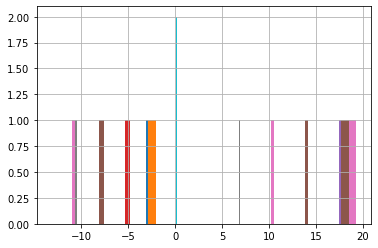

In [349]:
temp['diff'].hist()

In [347]:
temp['diff']

0                           (0.0, 9.307413903864439e-12)
1                         (0.0, -6.6135535659039846e-09)
2                           (0.0, 7.464916115806908e-09)
3      (-2.4868995751603507e-14, -6.951839395807902e-09)
4      (-8.881784197001252e-14, -2.8591420619950014e-09)
                             ...                        
495            (19.492674295286037, -13.132403874568011)
496             (19.49186027710514, -13.169845792963915)
497            (19.491153482734315, -13.207225400701425)
498            (19.490320290021685, -13.244678734083351)
499            (19.116606858897953, -13.499097752961955)
Name: diff, Length: 500, dtype: object